In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import load_model

import tensorflow as tf

### Prediction Function

In [14]:
def prediction_nucleus(model_path, X_test, img_size = (256, 256), thres = 0.5, verbose = 1):
    # Predict on train, val and test
    model = load_model(model_path)
    preds_test = model.predict(X_test, verbose=verbose)

    # Threshold predictions
    preds_test_t = (preds_test > thres).astype(np.uint8)

    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test_t)):
        preserve = np.squeeze(preds_test_t[i])
        res = resize(preserve, img_size, mode='constant', preserve_range=True)
        preds_test_upsampled.append(res.astype(np.uint8))
    return preds_test_upsampled

### Watershed for nucleus split

In [15]:
import cv2
import scipy.ndimage as ndi
from skimage.segmentation import watershed, find_boundaries
from skimage.feature import corner_peaks
from skimage.morphology import binary_dilation, disk
from skimage.color import label2rgb
from skimage.measure import regionprops_table

def make_boundary_image(L, A, thickness=1, color=(255,255,85), rescale_hist=True):
    if A.ndim == 2:
        A = np.stack((A,A,A), axis=2)
    if rescale_hist:
        A = np.interp(A, (np.amin(A), np.amax(A)), (0,255)).astype(np.uint8)
    else:
        A = A.astype(np.uint8)

    mask = find_boundaries(L)
    mask = binary_dilation(mask, footprint=disk(thickness))

    R = A[:,:,0].copy()
    G = A[:,:,1].copy()
    B = A[:,:,2].copy()

    R[mask] = color[0]
    G[mask] = color[1]
    B[mask] = color[2]

    return np.stack((R,G,B), axis=2)

def labelvis(A, L, bg_color='b'):
    bg_color_code = {
        'b': (0.1,0.1,0.5),
        'g': (0.1,0.5,0.1),
    }  
    A = label2rgb(L, A, bg_label=0, bg_color=bg_color_code[bg_color], alpha=0.3, image_alpha=1)
    A = np.interp(A, (0,1), (0,255)).astype(np.uint8)
    A = make_boundary_image(L, A)
    return A

# Create predict boundary image with label
# Input: image, label
# Output: rgb_watershed, boundary, mask, dataframe
def create_boundary(img, label):
    #Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
    ret1, thresh = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(label, peak_markers, mask=label)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)
    boundary = labelvis(img, markers)
    
    # regionprops function in skimage measure module calculates useful parameters for each object.
    params = ['label', 'area', 'bbox', 'equivalent_diameter', 'mean_intensity', 'solidity']
    props = regionprops_table(markers, intensity_image=X_test[0], properties=params)
    df = pd.DataFrame(props)
    
    return img_rgb, boundary, markers, df

## DSC and IoI

In [16]:
def dsc_cal(img1, img2):
    img1 = img1.astype(bool)
    img2 = img2.astype(bool)
    intersection = np.logical_and(img1, img2)
    dsc = 2 * intersection.sum() / (img1.sum() + img2.sum())
    return dsc

In [17]:
def iou_cal(img1, img2):
    img1 = img1.astype(bool)
    img2 = img2.astype(bool)
    intersection = np.logical_and(img1, img2)
    union = np.logical_or(img1, img2)
    iou = intersection.sum() / union.sum()
    return iou

## Get Test data

In [18]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/stage1_train/'
TEST_PATH = 'dataset/stage1_test/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

os.getcwd()

'/Users/cusniwtt/Documents/GitHub/unet-nucleus'

In [19]:
# Get train and test IDs
#train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [20]:
# Get and resize train images and masks
"""
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    X_train[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_train[n] = mask
"""

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img

    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_test[n] = mask

print('Done!')

Getting and resizing test images ... 


100%|██████████| 12/12 [00:01<00:00, 11.99it/s]

Done!


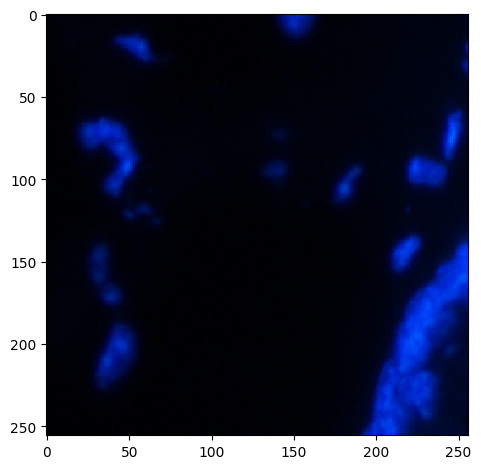

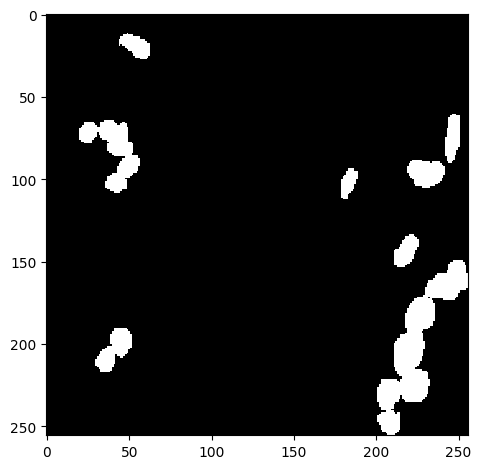

In [21]:
# Check if training data looks all right
#ix = random.randint(0, len(train_ids))
imshow(X_test[0])
plt.show()
imshow(np.squeeze(Y_test[0]))
plt.show()

# Prediction

In [22]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

## U-Net 64

### Adam, BCE

In [38]:
w_path = 'weights/unet_64_adam_bce_8.h5'
model = load_model(w_path)
Y_pred = []
actual_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)
    actual_pred.append(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

(12, 256, 256, 3)
(12, 256, 256)


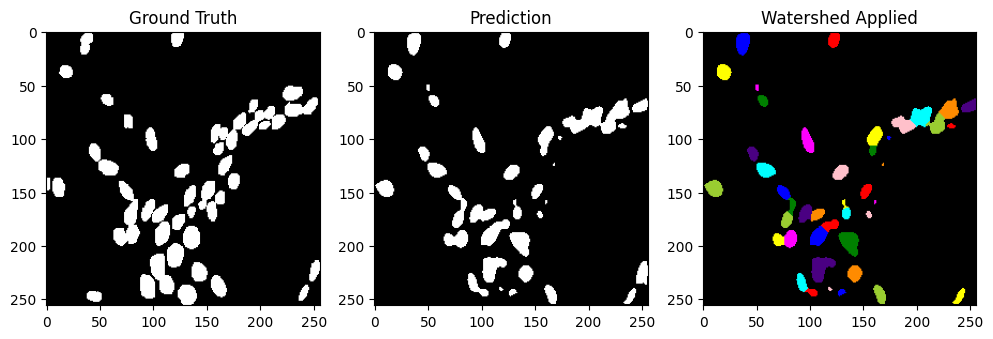

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
row = 0
col = 0
i = 5
axs[0].imshow(Y_test[i], cmap='gray')
axs[1].imshow(actual_pred[i], cmap='gray')
axs[2].imshow(np.squeeze(Y_pred[i]), cmap='gray')
axs[0].set_title('Ground Truth')
axs[1].set_title('Prediction')
axs[2].set_title('Watershed Applied')
plt.show()

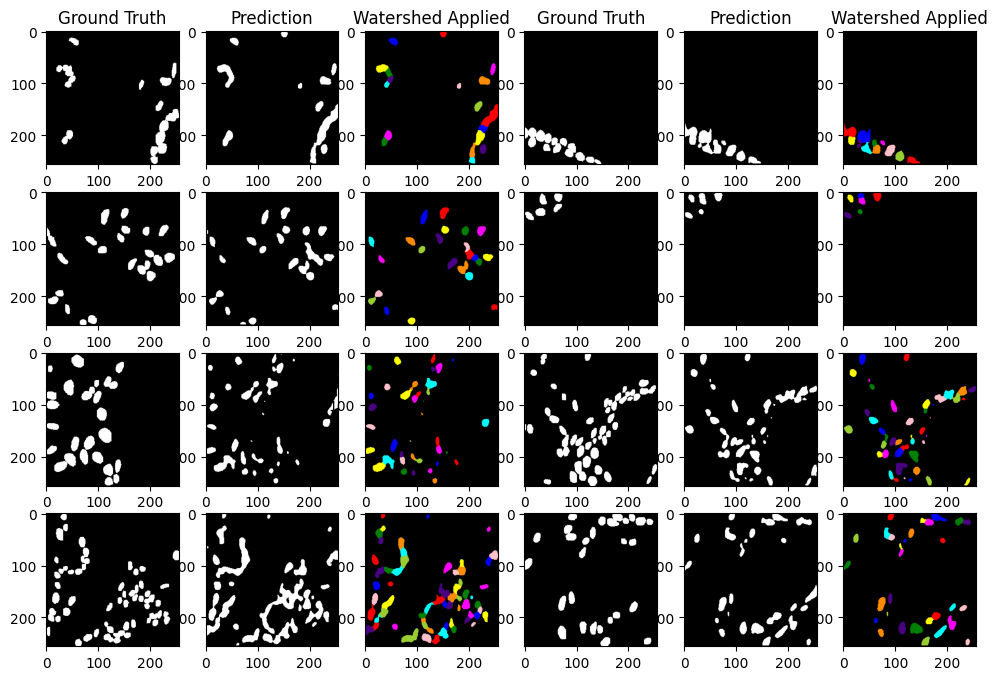

In [44]:
fig, axs = plt.subplots(4, 6, figsize=(12, 8))
row = 0
col = 0
for i in range(8):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(actual_pred[i], cmap='gray')
  axs[row][col+2].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  col = col + 3
  if col == 6:
    col = 0
    row = row + 1

axs[0][0].set_title('Ground Truth')
axs[0][1].set_title('Prediction')
axs[0][2].set_title('Watershed Applied')
axs[0][3].set_title('Ground Truth')
axs[0][4].set_title('Prediction')
axs[0][5].set_title('Watershed Applied')
plt.show()

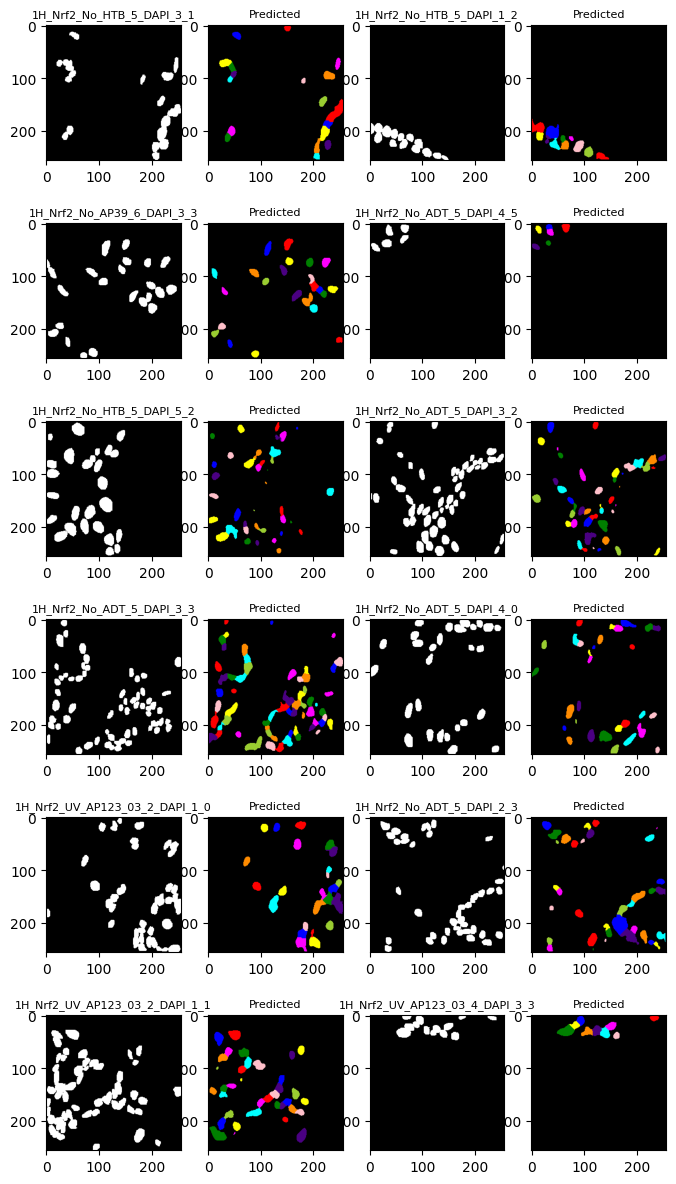

In [24]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [35]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/unet_64_adam_bce_8.csv', index=False)
df

/var/folders/jf/lsmfc7bs28lcf730tztyl6vw0000gn/T/ipykernel_62153/2132037560.py:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = df.mean()


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_3_1,0.818111,0.692206
1,1H_Nrf2_No_HTB_5_DAPI_1_2,0.792843,0.656785
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.782674,0.642945
3,1H_Nrf2_No_ADT_5_DAPI_4_5,0.648352,0.479675
4,1H_Nrf2_No_HTB_5_DAPI_5_2,0.538524,0.368480
5,1H_Nrf2_No_ADT_5_DAPI_3_2,0.645806,0.476894
6,1H_Nrf2_No_ADT_5_DAPI_3_3,0.690764,0.527608
7,1H_Nrf2_No_ADT_5_DAPI_4_0,0.677826,0.512660
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.747584,0.596913
9,1H_Nrf2_No_ADT_5_DAPI_2_3,0.786397,0.647986


### SGD, BCE

In [36]:
w_path = 'weights/unet_64_sgd_bce_8.h5'
model = load_model(w_path)
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

(12, 256, 256, 3)
(12, 256, 256)


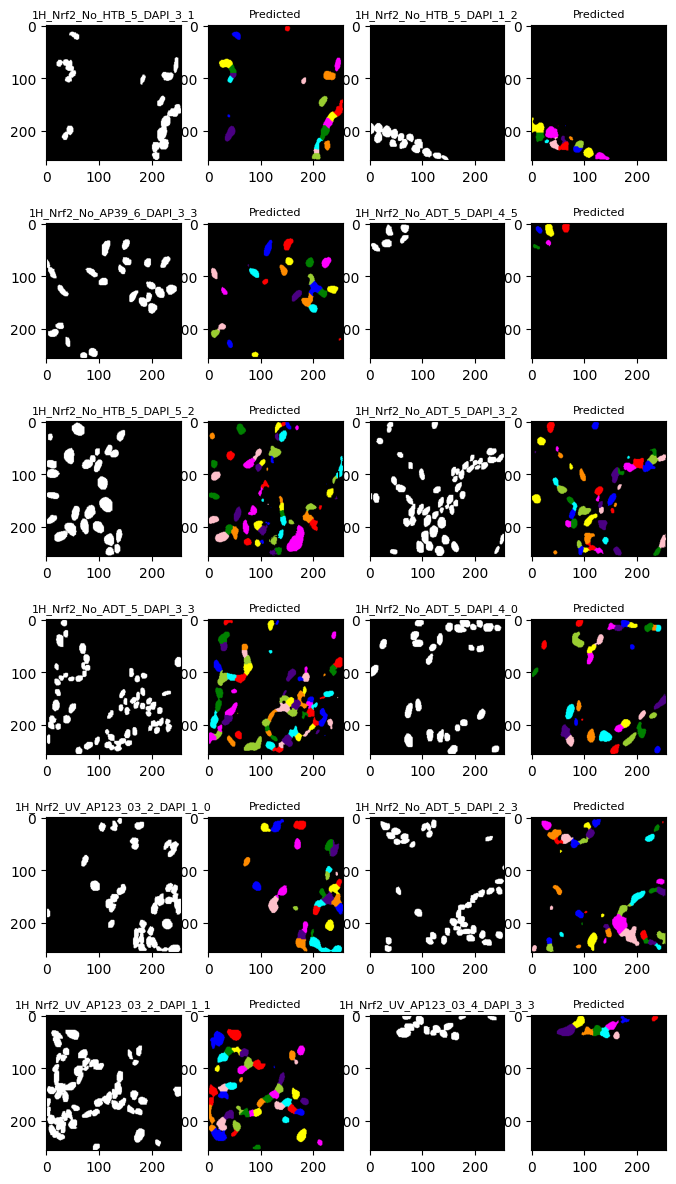

In [37]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [38]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/unet_64_sgd_bce_8.csv', index=False)
df

/var/folders/jf/lsmfc7bs28lcf730tztyl6vw0000gn/T/ipykernel_62153/3135018947.py:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = df.mean()


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_3_1,0.818439,0.692676
1,1H_Nrf2_No_HTB_5_DAPI_1_2,0.799040,0.665334
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.789845,0.652680
3,1H_Nrf2_No_ADT_5_DAPI_4_5,0.616986,0.446117
4,1H_Nrf2_No_HTB_5_DAPI_5_2,0.570122,0.398721
5,1H_Nrf2_No_ADT_5_DAPI_3_2,0.715291,0.556773
6,1H_Nrf2_No_ADT_5_DAPI_3_3,0.650899,0.482469
7,1H_Nrf2_No_ADT_5_DAPI_4_0,0.693897,0.531273
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.777098,0.635454
9,1H_Nrf2_No_ADT_5_DAPI_2_3,0.744970,0.593587


### Adam, DICE+Jaccard

In [40]:
w_path = 'weights/unet_64_adam_dice+jacard_8.h5'
model = load_model(w_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'jacard_coef_loss': jacard_coef_loss, 'dice_coef': dice_coef, 'jacard_coef': jacard_coef})
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

(12, 256, 256, 3)
(12, 256, 256)


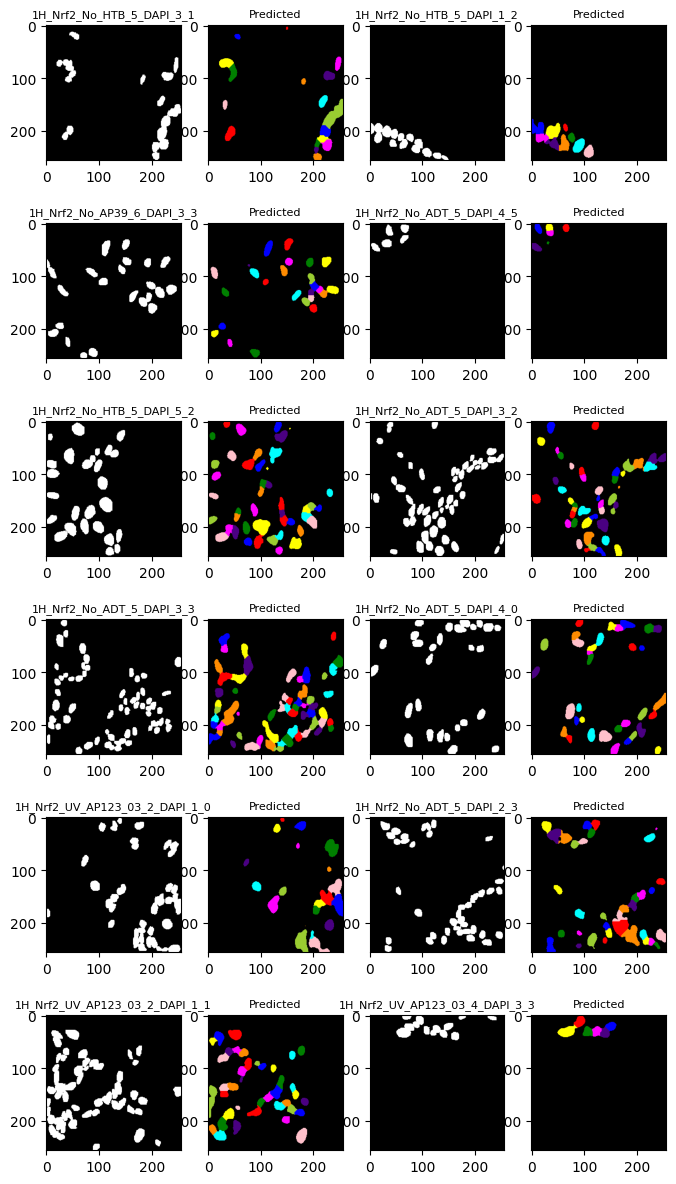

In [41]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [42]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/unet_64_adam_dice+jacard_8.csv', index=False)
df

/var/folders/jf/lsmfc7bs28lcf730tztyl6vw0000gn/T/ipykernel_62153/2976768653.py:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = df.mean()


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_3_1,0.809039,0.679317
1,1H_Nrf2_No_HTB_5_DAPI_1_2,0.740582,0.588036
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.805556,0.674419
3,1H_Nrf2_No_ADT_5_DAPI_4_5,0.581502,0.409942
4,1H_Nrf2_No_HTB_5_DAPI_5_2,0.570753,0.399338
5,1H_Nrf2_No_ADT_5_DAPI_3_2,0.696421,0.534238
6,1H_Nrf2_No_ADT_5_DAPI_3_3,0.644538,0.475512
7,1H_Nrf2_No_ADT_5_DAPI_4_0,0.693659,0.530994
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.735114,0.581170
9,1H_Nrf2_No_ADT_5_DAPI_2_3,0.730490,0.575411


### SGD, DICE+Jaccard

In [43]:
w_path = 'weights/unet_64_sgd_dice+jacard_8.h5'
model = load_model(w_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'jacard_coef_loss': jacard_coef_loss, 'dice_coef': dice_coef, 'jacard_coef': jacard_coef})
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

(12, 256, 256, 3)
(12, 256, 256)


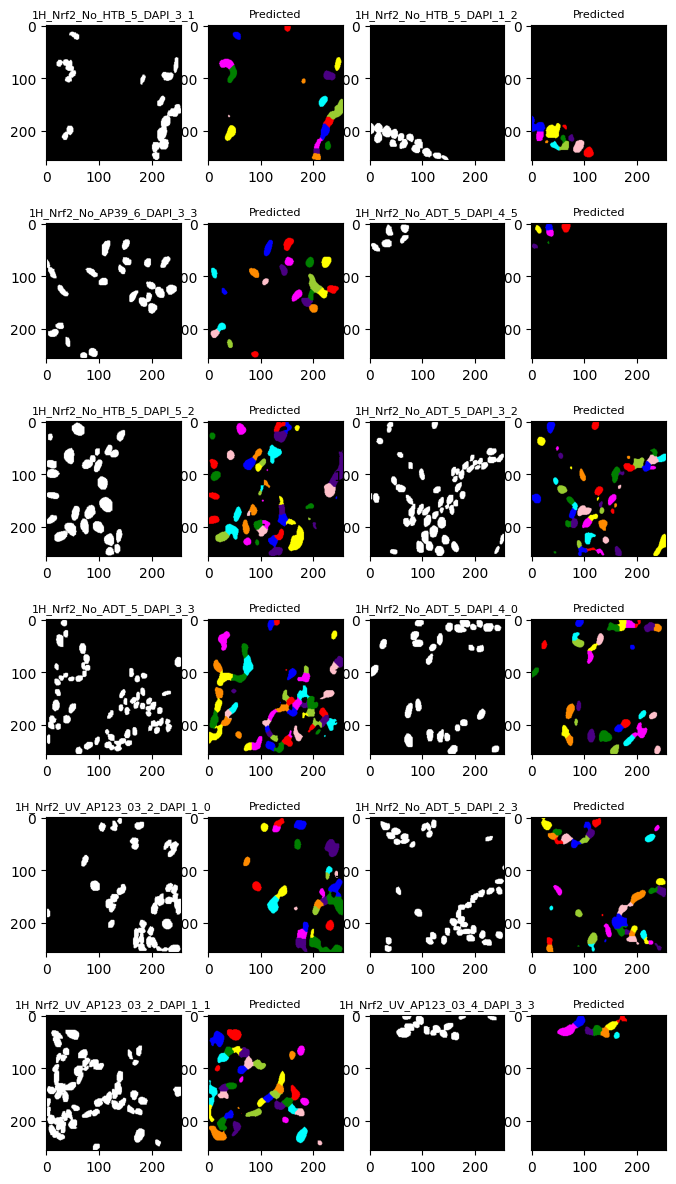

In [44]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [45]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/unet_64_sgd_dice+jacard_8.csv', index=False)
df

/var/folders/jf/lsmfc7bs28lcf730tztyl6vw0000gn/T/ipykernel_62153/2281161918.py:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = df.mean()


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_3_1,0.810931,0.681988
1,1H_Nrf2_No_HTB_5_DAPI_1_2,0.742576,0.590553
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.794933,0.659658
3,1H_Nrf2_No_ADT_5_DAPI_4_5,0.549171,0.378522
4,1H_Nrf2_No_HTB_5_DAPI_5_2,0.584335,0.412763
5,1H_Nrf2_No_ADT_5_DAPI_3_2,0.700143,0.538631
6,1H_Nrf2_No_ADT_5_DAPI_3_3,0.660355,0.492933
7,1H_Nrf2_No_ADT_5_DAPI_4_0,0.726880,0.570944
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.791655,0.655156
9,1H_Nrf2_No_ADT_5_DAPI_2_3,0.757986,0.610288


## IRNV2 U_Net

### Adam, BCE

In [12]:
w_path = 'weights/irnv2_unet_64_adam_bce_8.h5'
model = load_model(w_path)
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

/Users/cusniwtt/opt/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: keras.applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


ValueError: bad marshal data (unknown type code)

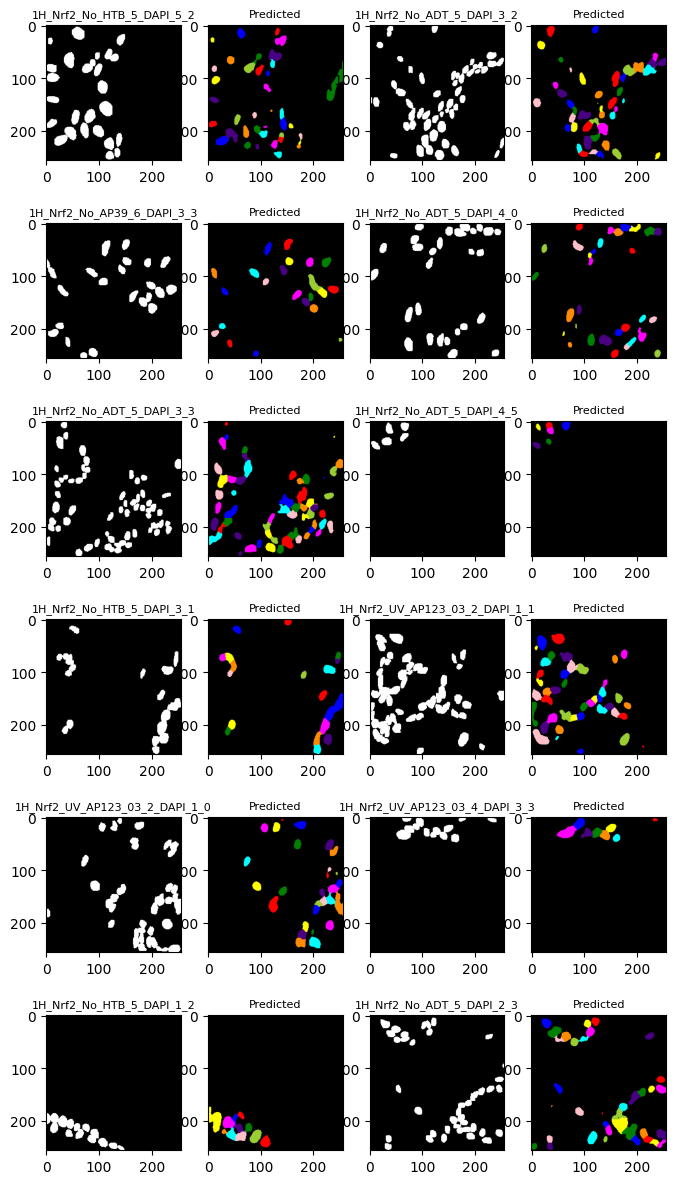

In [39]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [40]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/irnv2_unet_64_adam_bce_8.csv', index=False)
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_5_2,0.566681,0.395363
1,1H_Nrf2_No_ADT_5_DAPI_3_2,0.738637,0.585586
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.791245,0.654595
3,1H_Nrf2_No_ADT_5_DAPI_4_0,0.699178,0.537489
4,1H_Nrf2_No_ADT_5_DAPI_3_3,0.700328,0.538850
5,1H_Nrf2_No_ADT_5_DAPI_4_5,0.682171,0.517647
6,1H_Nrf2_No_HTB_5_DAPI_3_1,0.823765,0.700341
7,1H_Nrf2_UV_AP123_03_2_DAPI_1_1,0.804495,0.672933
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.742793,0.590828
9,1H_Nrf2_UV_AP123_03_4_DAPI_3_3,0.804938,0.673554


### SGD, BCE

In [43]:
w_path = 'weights/irnv2_unet_64_sgd_bce_8.h5'
model = load_model(w_path)
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

(12, 256, 256, 3)
(12, 256, 256)


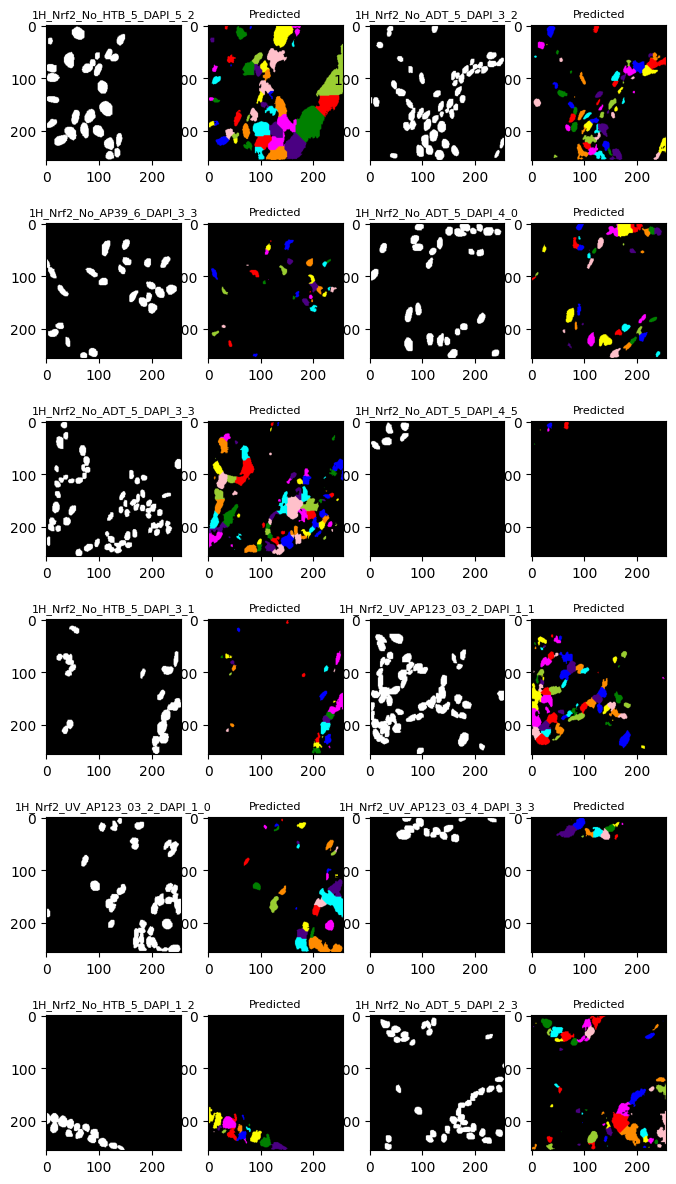

In [44]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [45]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/irnv2_unet_64_sgd_bce_8.csv', index=False)
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_5_2,0.427961,0.272233
1,1H_Nrf2_No_ADT_5_DAPI_3_2,0.708328,0.548381
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.597176,0.425696
3,1H_Nrf2_No_ADT_5_DAPI_4_0,0.684604,0.520455
4,1H_Nrf2_No_ADT_5_DAPI_3_3,0.628703,0.458473
5,1H_Nrf2_No_ADT_5_DAPI_4_5,0.303471,0.178877
6,1H_Nrf2_No_HTB_5_DAPI_3_1,0.660427,0.493014
7,1H_Nrf2_UV_AP123_03_2_DAPI_1_1,0.775931,0.633895
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.729257,0.573882
9,1H_Nrf2_UV_AP123_03_4_DAPI_3_3,0.745979,0.594870


### Adam, DICE+Jaccard

In [46]:
w_path = 'weights/irnv2_unet_64_adam_dice+jacard_8.h5'
model = load_model(w_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'jacard_coef_loss': jacard_coef_loss, 'dice_coef': dice_coef, 'jacard_coef': jacard_coef})
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

/opt/conda/lib/python3.7/site-packages/keras/layers/core/lambda_layer.py:325: UserWarning: keras.applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  config, custom_objects, "function", "module", "function_type"


(12, 256, 256, 3)
(12, 256, 256)


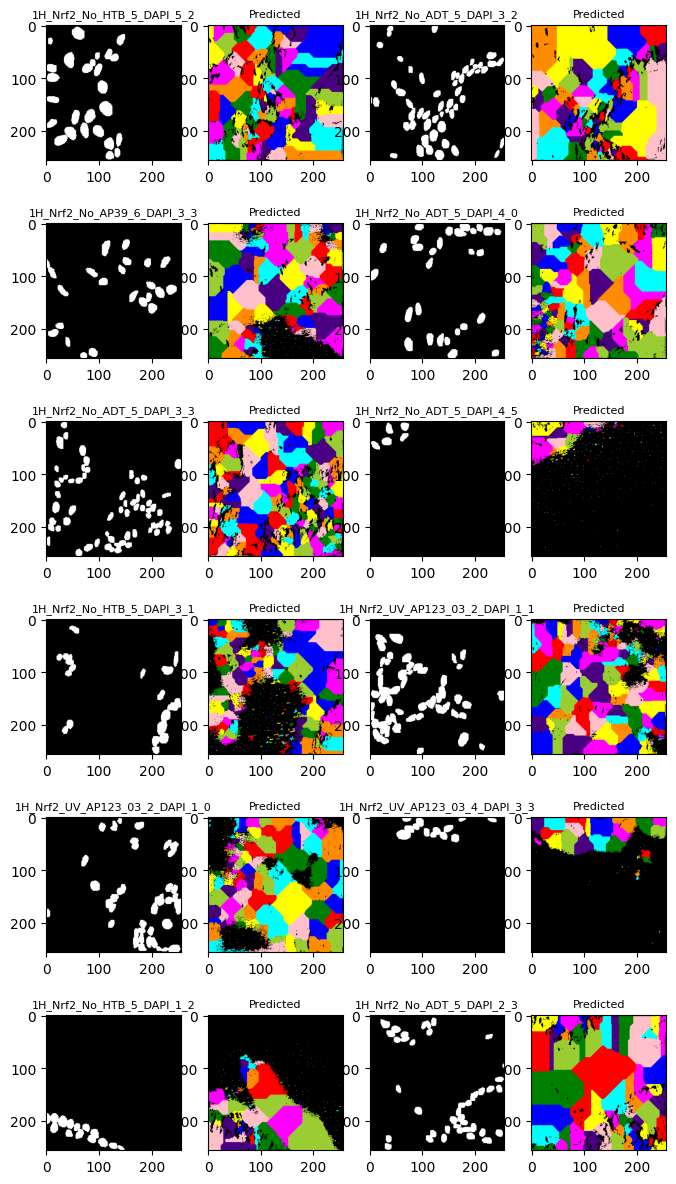

In [47]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [48]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/irnv2_unet_64_adam_dice+jacard_8.csv', index=False)
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_5_2,0.191163,0.105683
1,1H_Nrf2_No_ADT_5_DAPI_3_2,0.189366,0.104585
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.137783,0.073989
3,1H_Nrf2_No_ADT_5_DAPI_4_0,0.154260,0.083576
4,1H_Nrf2_No_ADT_5_DAPI_3_3,0.206397,0.115074
5,1H_Nrf2_No_ADT_5_DAPI_4_5,0.231921,0.131171
6,1H_Nrf2_No_HTB_5_DAPI_3_1,0.133179,0.071340
7,1H_Nrf2_UV_AP123_03_2_DAPI_1_1,0.301021,0.177178
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.224755,0.126605
9,1H_Nrf2_UV_AP123_03_4_DAPI_3_3,0.282075,0.164195


### SGD, DICE+Jaccard

In [49]:
w_path = 'weights/irnv2_unet_64_sgd_dice+jacard_8.h5'
model = load_model(w_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'jacard_coef_loss': jacard_coef_loss, 'dice_coef': dice_coef, 'jacard_coef': jacard_coef})
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

/opt/conda/lib/python3.7/site-packages/keras/layers/core/lambda_layer.py:325: UserWarning: keras.applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  config, custom_objects, "function", "module", "function_type"


(12, 256, 256, 3)
(12, 256, 256)


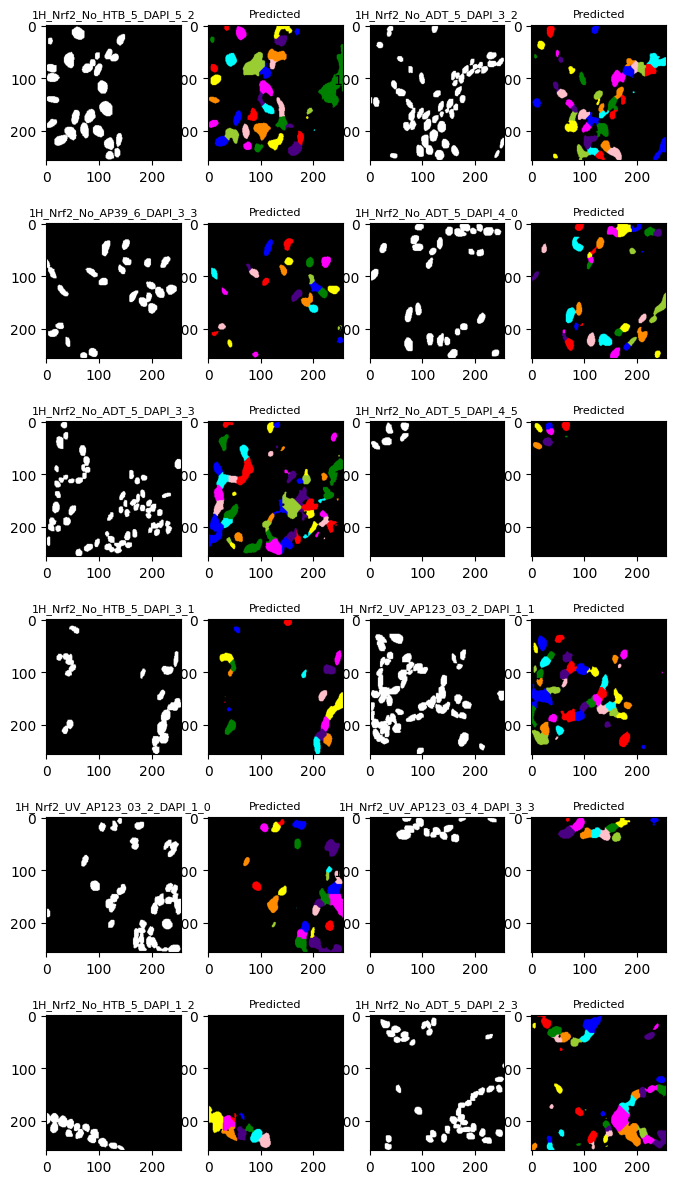

In [50]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [51]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/irnv2_unet_64_sgd_dice+jacard_8.csv', index=False)
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_5_2,0.575481,0.403983
1,1H_Nrf2_No_ADT_5_DAPI_3_2,0.748978,0.598693
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.773631,0.630830
3,1H_Nrf2_No_ADT_5_DAPI_4_0,0.716468,0.558200
4,1H_Nrf2_No_ADT_5_DAPI_3_3,0.616911,0.446039
5,1H_Nrf2_No_ADT_5_DAPI_4_5,0.746172,0.595115
6,1H_Nrf2_No_HTB_5_DAPI_3_1,0.815527,0.688514
7,1H_Nrf2_UV_AP123_03_2_DAPI_1_1,0.772153,0.628867
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.788976,0.651494
9,1H_Nrf2_UV_AP123_03_4_DAPI_3_3,0.778995,0.637995


## RA U-Net

In [52]:
from keras import backend as K

### Adam, BCE

In [53]:
w_path = 'weights/ra_unet_64_adam_bce_8.h5'
model = load_model(w_path)
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

(12, 256, 256, 3)
(12, 256, 256)


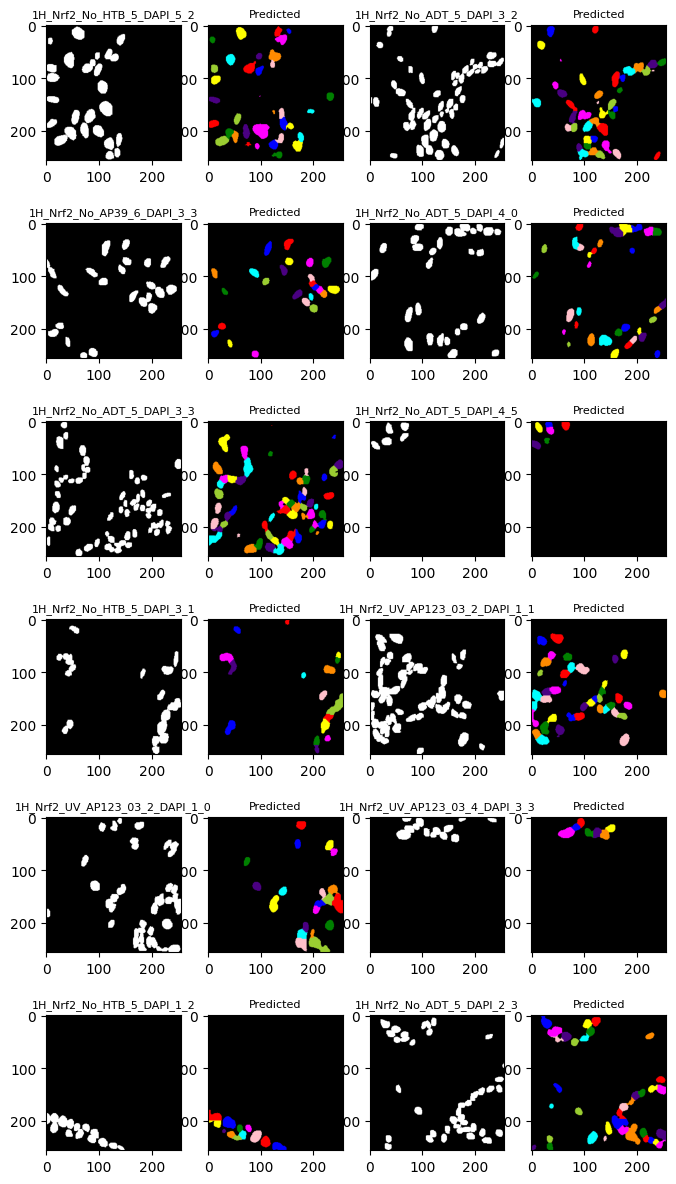

In [54]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [55]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/ra_unet_64_adam_bce_8.csv', index=False)
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_5_2,0.618958,0.448181
1,1H_Nrf2_No_ADT_5_DAPI_3_2,0.728269,0.572660
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.801534,0.668800
3,1H_Nrf2_No_ADT_5_DAPI_4_0,0.662840,0.495707
4,1H_Nrf2_No_ADT_5_DAPI_3_3,0.670939,0.504822
5,1H_Nrf2_No_ADT_5_DAPI_4_5,0.645407,0.476458
6,1H_Nrf2_No_HTB_5_DAPI_3_1,0.803156,0.671062
7,1H_Nrf2_UV_AP123_03_2_DAPI_1_1,0.791291,0.654658
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.740897,0.588433
9,1H_Nrf2_UV_AP123_03_4_DAPI_3_3,0.757701,0.609918


### SGD, BCE

In [56]:
w_path = 'weights/ra_unet_64_sgd_bce_8.h5'
model = load_model(w_path)
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

(12, 256, 256, 3)
(12, 256, 256)


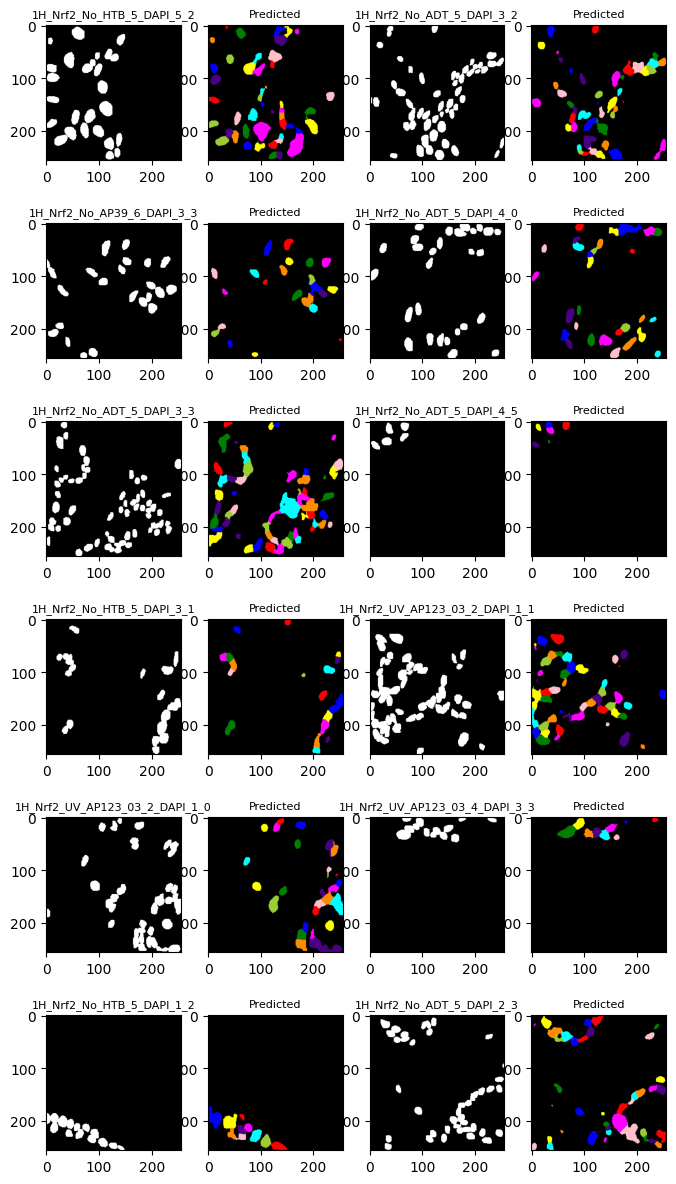

In [57]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [58]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/ra_unet_64_sgd_bce_8.csv', index=False)
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_5_2,0.577574,0.406049
1,1H_Nrf2_No_ADT_5_DAPI_3_2,0.729607,0.574315
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.774699,0.632252
3,1H_Nrf2_No_ADT_5_DAPI_4_0,0.708046,0.548042
4,1H_Nrf2_No_ADT_5_DAPI_3_3,0.663877,0.496868
5,1H_Nrf2_No_ADT_5_DAPI_4_5,0.590221,0.418662
6,1H_Nrf2_No_HTB_5_DAPI_3_1,0.798390,0.664434
7,1H_Nrf2_UV_AP123_03_2_DAPI_1_1,0.790111,0.653044
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.787326,0.649248
9,1H_Nrf2_UV_AP123_03_4_DAPI_3_3,0.791403,0.654811


### Adam, DICE + Jaccard

In [60]:
w_path = 'weights/ra_unet_64_adam_dice+jacard_8.h5'
model = load_model(w_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'jacard_coef_loss': jacard_coef_loss, 'dice_coef': dice_coef, 'jacard_coef': jacard_coef})
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

(12, 256, 256, 3)
(12, 256, 256)


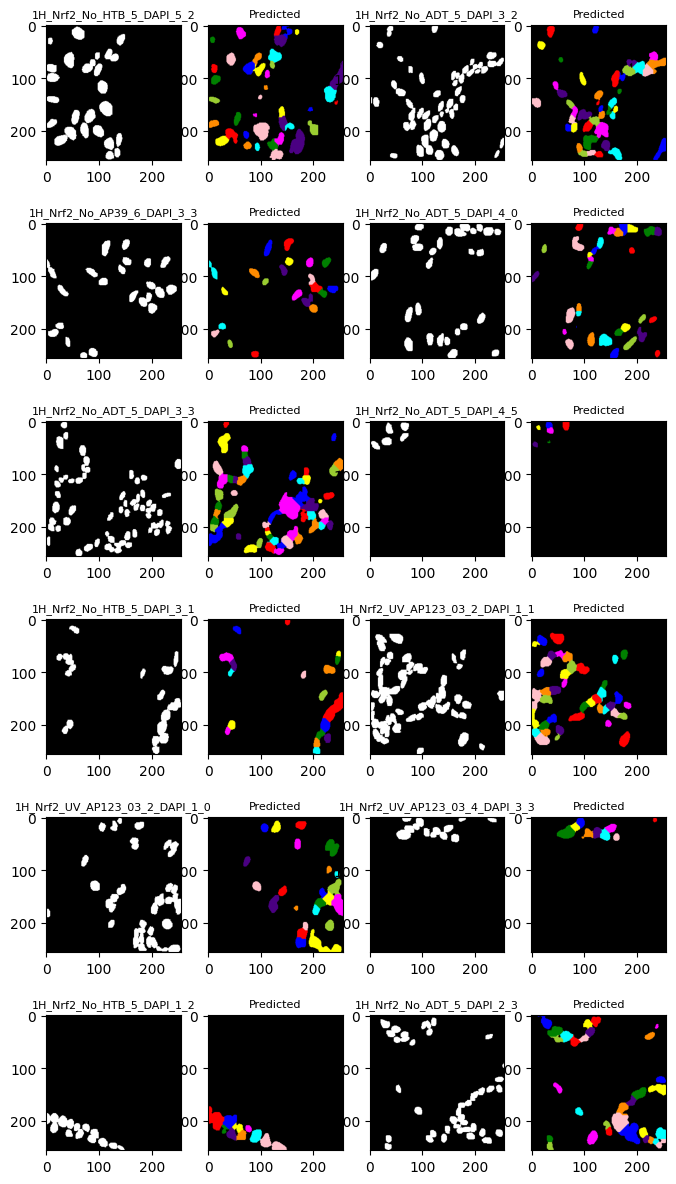

In [61]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [62]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/ra_unet_64_adam_dice+jacard_8.csv', index=False)
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_5_2,0.542064,0.371802
1,1H_Nrf2_No_ADT_5_DAPI_3_2,0.739014,0.586061
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.806455,0.675680
3,1H_Nrf2_No_ADT_5_DAPI_4_0,0.742544,0.590513
4,1H_Nrf2_No_ADT_5_DAPI_3_3,0.647321,0.478547
5,1H_Nrf2_No_ADT_5_DAPI_4_5,0.582171,0.410607
6,1H_Nrf2_No_HTB_5_DAPI_3_1,0.830193,0.709684
7,1H_Nrf2_UV_AP123_03_2_DAPI_1_1,0.789755,0.652558
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.787411,0.649363
9,1H_Nrf2_UV_AP123_03_4_DAPI_3_3,0.801709,0.669044


### SGD, DICE + Jaccard

In [63]:
w_path = 'weights/ra_unet_64_sgd_dice+jacard_8.h5'
model = load_model(w_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'jacard_coef_loss': jacard_coef_loss, 'dice_coef': dice_coef, 'jacard_coef': jacard_coef})
Y_pred = []
Y_pred_mask = []
for i in range(X_test.shape[0]):
    pred = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred)

    ret1, thresh = cv2.threshold(pred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(pred, peak_markers, mask=pred)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)

    Y_pred.append(img_rgb)
    Y_pred_mask.append(markers)
Y_pred = np.array(Y_pred)
Y_pred_mask = np.array(Y_pred_mask)
print(Y_pred.shape)
print(Y_pred_mask.shape)

(12, 256, 256, 3)
(12, 256, 256)


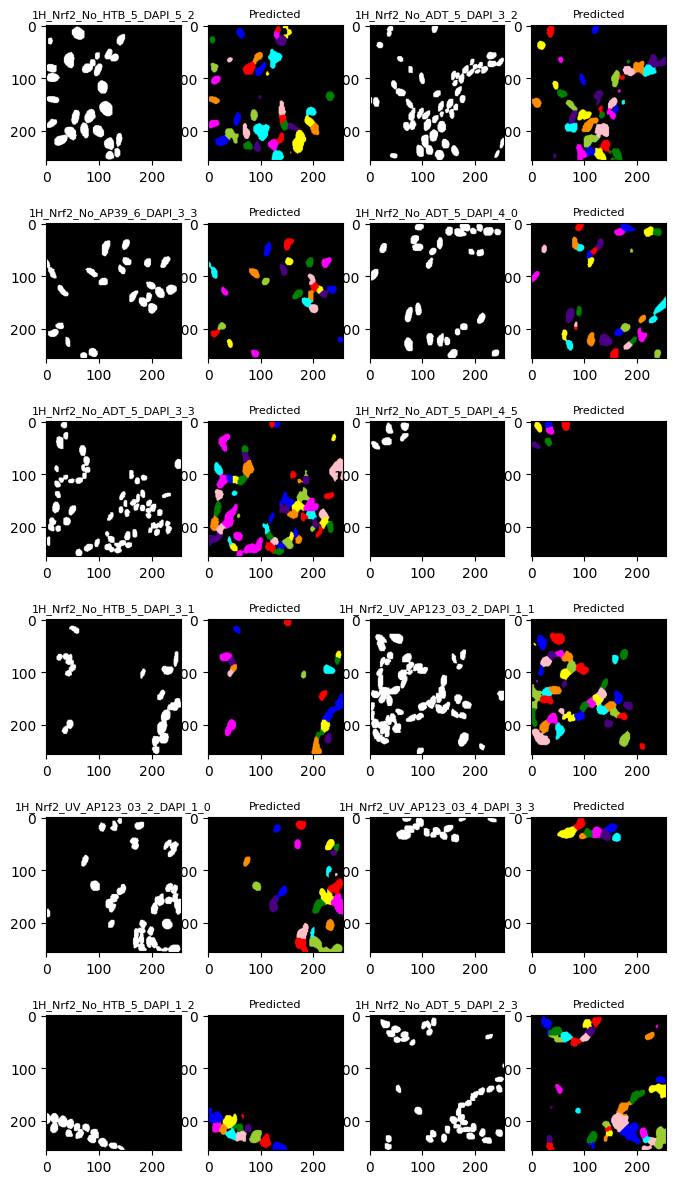

In [64]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  axs[row][col].set_title(test_ids[i], fontsize=8)
  axs[row][col+1].set_title('Predicted', fontsize=8)
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
plt.show()

In [65]:
df = pd.DataFrame(columns=['id', 'dsc', 'iou'])
for i, pred in enumerate(zip(Y_test, Y_pred_mask)):
    test = pred[0].squeeze()
    pred = pred[1]
    dsc_score = dsc_cal(test, pred)
    iou_score = iou_cal(test, pred)
    row = [test_ids[i], dsc_score, iou_score]
    df.loc[i] = row

mean = df.mean()
df.loc[df.shape[0]+1] = ['Average', mean['dsc'], mean['iou']]
df.to_csv('score/ra_unet_64_sgd_dice+jacard_8.csv', index=False)
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,id,dsc,iou
0,1H_Nrf2_No_HTB_5_DAPI_5_2,0.546423,0.375916
1,1H_Nrf2_No_ADT_5_DAPI_3_2,0.722358,0.565384
2,1H_Nrf2_No_AP39_6_DAPI_3_3,0.802972,0.670804
3,1H_Nrf2_No_ADT_5_DAPI_4_0,0.677199,0.511944
4,1H_Nrf2_No_ADT_5_DAPI_3_3,0.652496,0.484226
5,1H_Nrf2_No_ADT_5_DAPI_4_5,0.671283,0.505212
6,1H_Nrf2_No_HTB_5_DAPI_3_1,0.805872,0.674862
7,1H_Nrf2_UV_AP123_03_2_DAPI_1_1,0.786590,0.648248
8,1H_Nrf2_UV_AP123_03_2_DAPI_1_0,0.780092,0.639468
9,1H_Nrf2_UV_AP123_03_4_DAPI_3_3,0.763037,0.616863
